In [46]:
from scipy import stats
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, date
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
%matplotlib inline

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [47]:
df = pd.read_csv('housing.csv')

In [48]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


# EDA

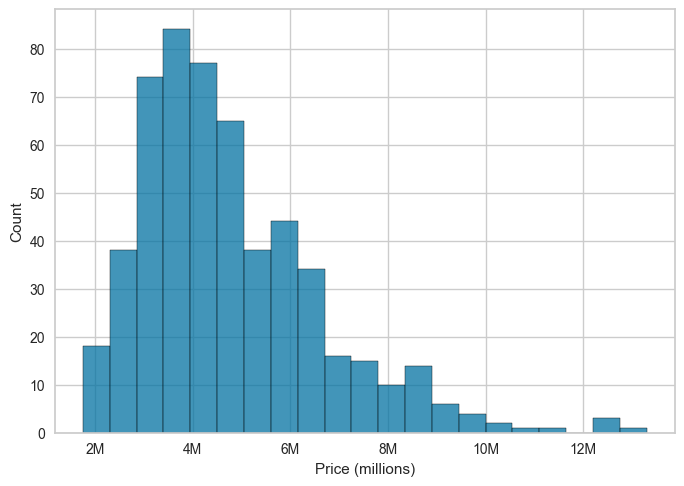

In [50]:
# Target variable overview

sns.histplot(df['price'])
def format_millions(x, pos):
    return f'{x / 1e6:.0f}M'

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_millions))

plt.xlabel('Price (millions)')
plt.show()

In [51]:
#briging price into millions scale
df['price'] = df['price']/1000000

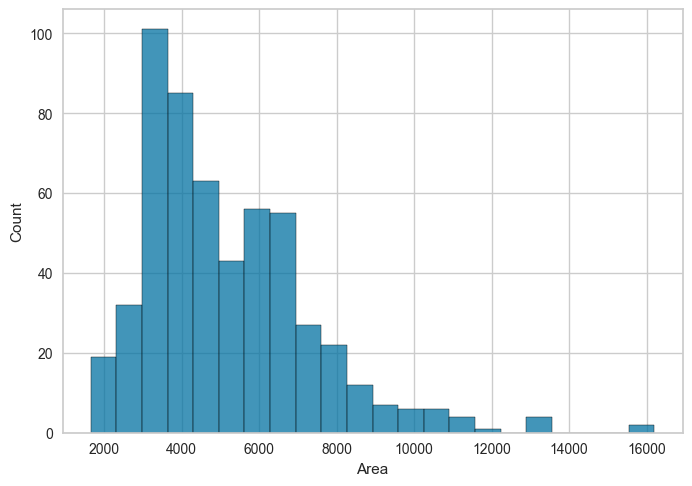

In [52]:
#Checking outliers among variables
sns.histplot(df['area'])

plt.xlabel('Area')
plt.show()

In [53]:
#pvalue of jarque bera test below 0.05, rejecting the null hypothesis that the area and price values follow a normal distribution
statistic, pvalueArea = scipy.stats.jarque_bera(df.area)
pvalueArea = round(pvalueArea, 3)
pvalueArea

statistic, pvaluePrice = scipy.stats.jarque_bera(df.price)
pvaluePrice = round(pvaluePrice, 3)
pvaluePrice, pvalueArea



(0.0, 0.0)

In [54]:
#handling area and price outliers
Q1_price = np.percentile(df['price'], 25)
Q3_price = np.percentile(df['price'], 75)
IQR_price = Q3_price - Q1_price

upper_bound_price = Q3_price + 1.5 * IQR_price
outliers_price = df['price'] > upper_bound_price

Q1_area = np.percentile(df['area'], 25)
Q3_area = np.percentile(df['area'], 75)
IQR_area = Q3_area - Q1_area

upper_bound_area = Q3_area + 1.5 * IQR_area

outliers_area = df['area'] > upper_bound_area

df = df[~(outliers_price | outliers_area)]

df.shape

(520, 13)

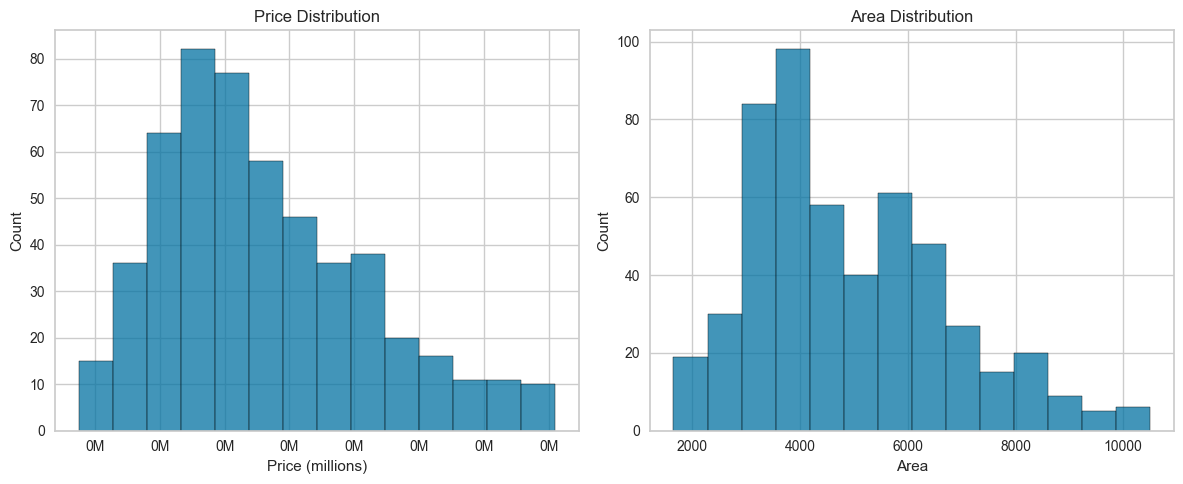

In [55]:
#distribution after outliers removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['price'])
def format_millions(x, pos):
    return f'{x / 1e6:.0f}M'

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_millions))
plt.xlabel('Price (millions)')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['area'])
plt.xlabel('Area')
plt.title('Area Distribution')

plt.tight_layout()


plt.show()



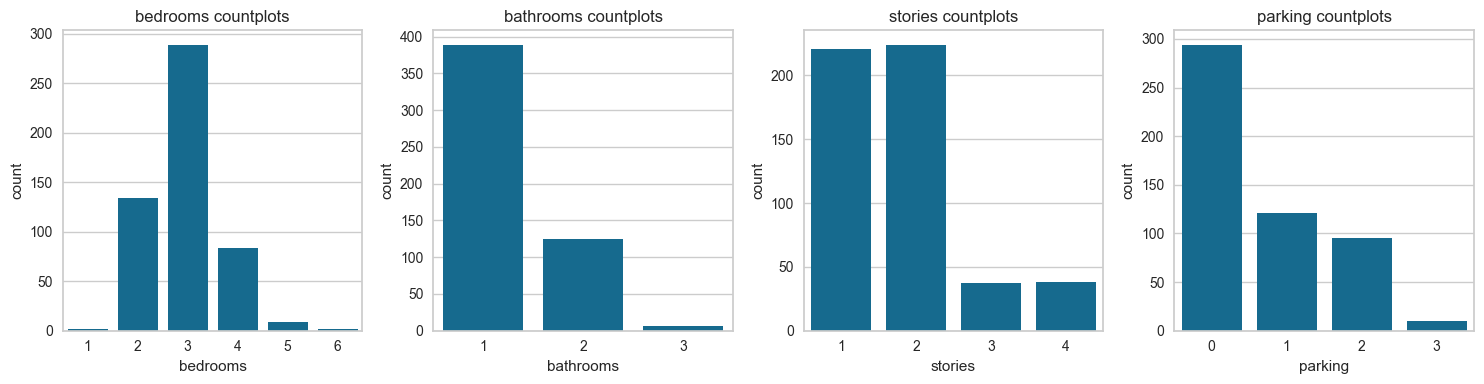

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

checkOutliers = ['bedrooms', 'bathrooms', 'stories', 'parking']

for i, coluna in enumerate(checkOutliers):
    sns.countplot(data=df, x=coluna, ax=axs[i])
    axs[i].set_title(f'{coluna} countplots')

plt.tight_layout()
plt.show()


## Checking Variables correlation

<Axes: xlabel='furnishingstatus', ylabel='price'>

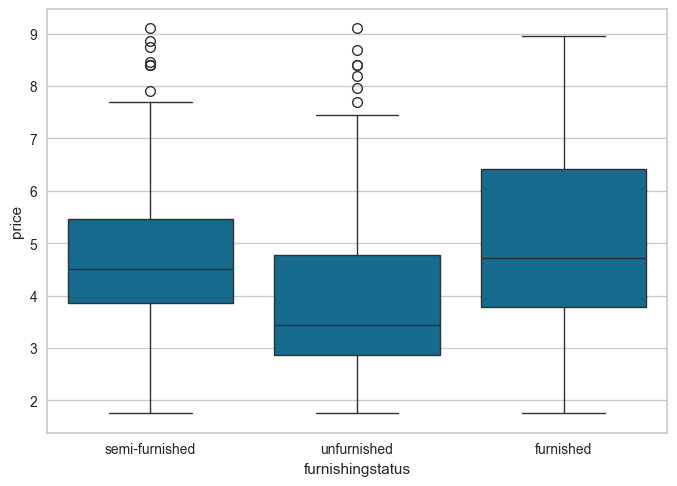

In [57]:
sns.boxplot(x='furnishingstatus',y='price',data=df)

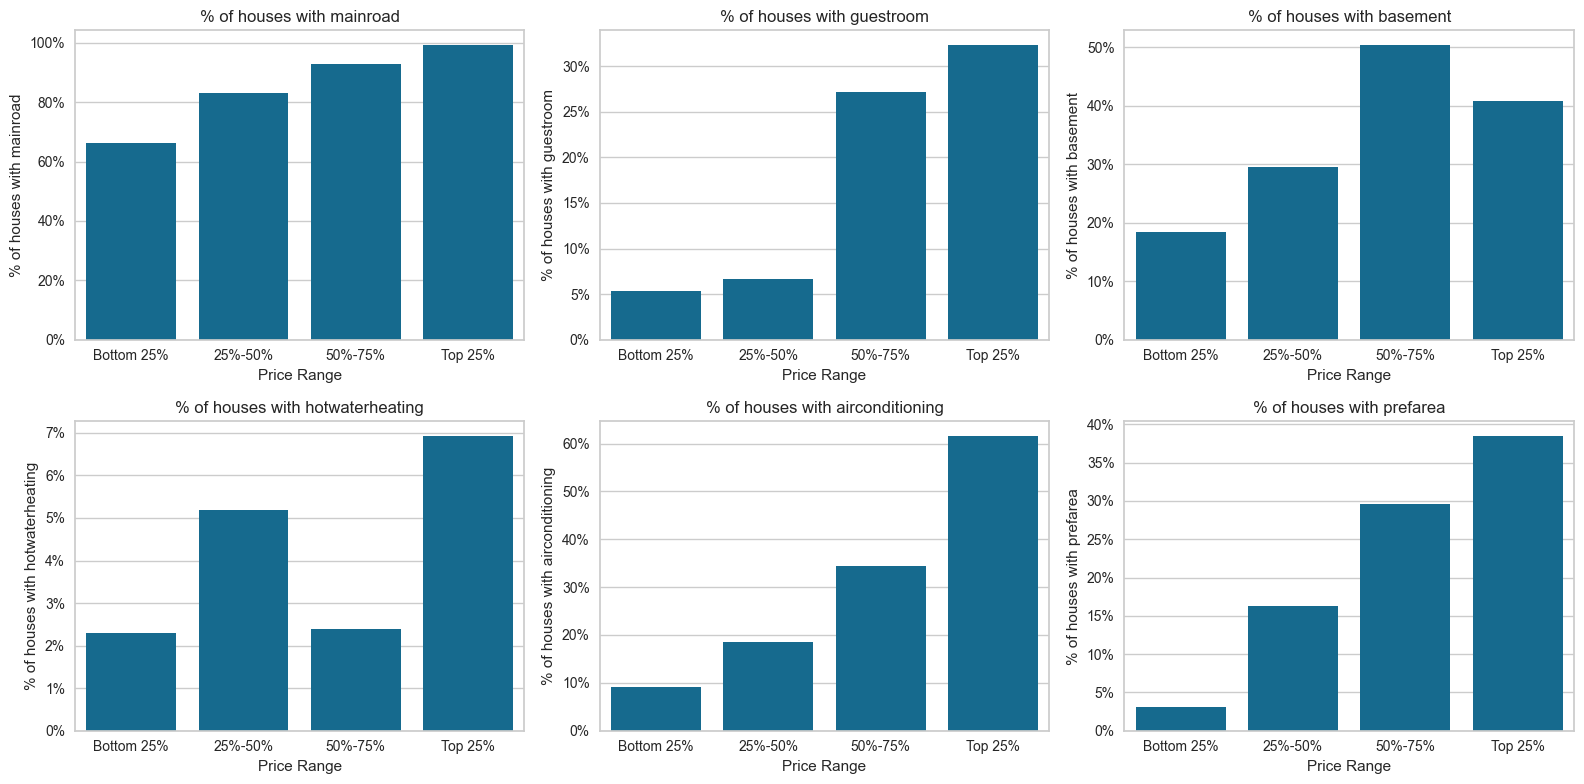

In [58]:
binaryVariables = ['mainroad','guestroom','basement', 'hotwaterheating','airconditioning', 'prefarea']

# Criando uma figura com vários subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

# Criando os gráficos de barra para cada coluna
for i, coluna in enumerate(binaryVariables):
    # Dividindo a coluna 'price' em quartis
    df['price_quartil'] = pd.qcut(df['price'], q=4, labels=['Bottom 25%', '25%-50%', '50%-75%', 'Top 25%'])
    # Calculando a proporção de "yes" para cada quartil de 'price'
    proporcao_por_quartil = df.groupby('price_quartil')[coluna].apply(lambda x: (x == 'yes').mean())
    # Criando o gráfico de barras
    linha = i // 3
    coluna = i % 3
    sns.barplot(x=proporcao_por_quartil.index, y=proporcao_por_quartil.values, ax=axs[linha, coluna])
    axs[linha, coluna].set_xlabel('Price Range')
    axs[linha, coluna].set_ylabel(f'% of houses with {binaryVariables[i]}')
    axs[linha, coluna].set_title(f'% of houses with {binaryVariables[i]}')
    axs[linha, coluna].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Ajustando o layout
plt.tight_layout()
plt.show()

In [59]:
#droping quartil column created on last cell, since it won't be used for future modeling
df = df.drop(columns=['price_quartil'])

<Axes: xlabel='area', ylabel='price'>

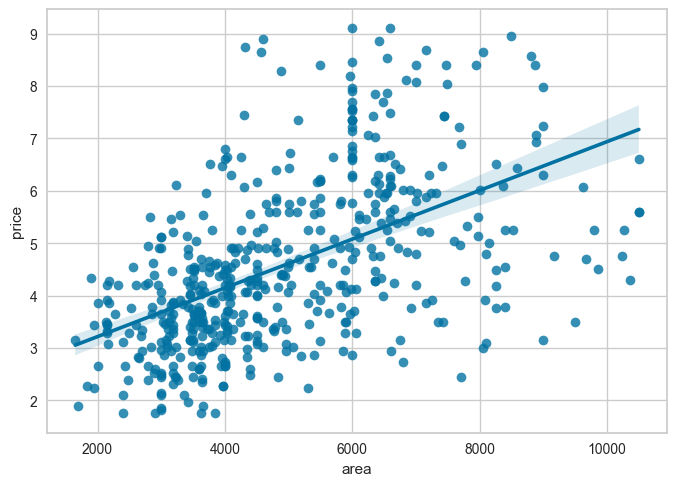

In [60]:
sns.regplot(x='area',y='price',data=df)

<Axes: >

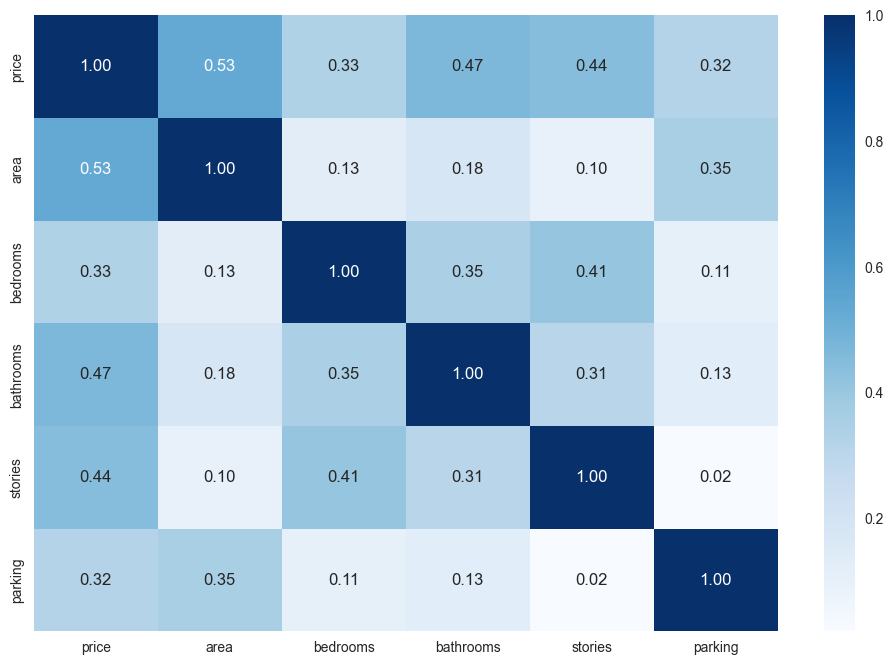

In [61]:
plt.figure(figsize=(12,8))
correlationNumeric = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
sns.heatmap(df[correlationNumeric].corr(),annot=True,cmap='Blues',fmt='.2f')

# Data Preparation

In [62]:
#Organizing the features for pipeline

#categorical columns
dummyVariables = ['mainroad','guestroom','basement', 'hotwaterheating','airconditioning', 'prefarea', 'furnishingstatus']

#numeric variables
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


In [63]:
#creating dummy variable for categorical columns
dummy=pd.get_dummies(df[dummyVariables],drop_first=True)
dummy=dummy.astype('int')

In [64]:
df=df.drop(columns=dummyVariables,axis=1)
df=pd.concat([df,dummy], axis=1)

In [65]:
x=df.drop('price', axis=1)
y=df['price']

In [66]:
#Scaling numeric variables

x_numeric = x[num_vars]

sc=RobustScaler()

x_numeric_scaled=sc.fit_transform(x_numeric)

x[num_vars] = x_numeric_scaled

In [67]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state = 1)

In [68]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((416, 13), (104, 13), (416,), (104,))

In [69]:
#linear regression
reg_model = LinearRegression()

reg_model_fit = reg_model.fit(x_train, y_train)

reg_train_predict = reg_model_fit.predict(x_train)
reg_test_predict = reg_model_fit.predict(x_test)

MSE_reg = {"Target" : ['Train', 'Test'],
       "MSE" : [mean_squared_error(y_train, reg_train_predict), mean_squared_error(y_test, reg_test_predict)],
        "MAE" : [mean_absolute_error(y_train, reg_train_predict), mean_absolute_error(y_test, reg_test_predict)],
        "MAPE" : [mean_absolute_percentage_error(y_train, reg_train_predict) * 100, mean_absolute_percentage_error(y_test, reg_test_predict) * 100]
}


MSE_reg = pd.DataFrame(MSE_reg)
MSE_reg

,Target,MSE,MAE,MAPE
0,Train,0.838881,0.698263,16.325021
1,Test,0.908443,0.680383,16.365118


In [71]:
r2_test = reg_model.score(x_test, y_test)
r2_test

0.6404548049612879

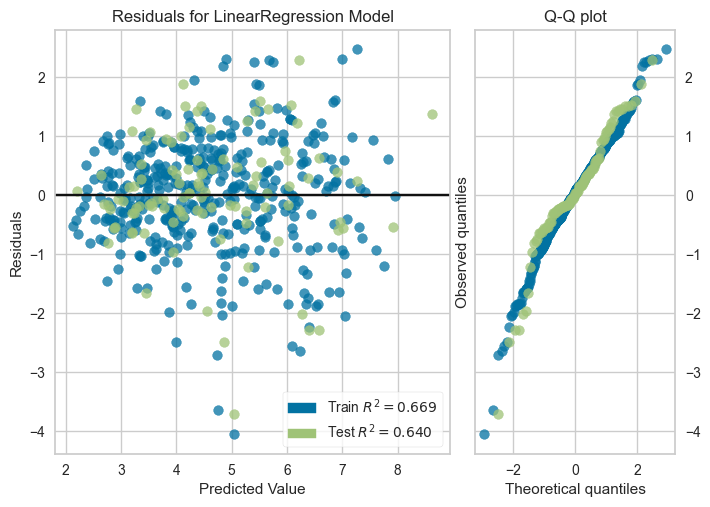

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [28]:
visualizer = ResidualsPlot(reg_model, hist = False, qqplot = True)
visualizer.fit(np.nan_to_num(x_train), y_train)
visualizer.score(np.nan_to_num(x_test), y_test)
visualizer.show()

In [29]:
#testing Polynomial, but it results in overfitiing

reg2_model = LinearRegression()
poly = PolynomialFeatures(degree =2)

x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.transform(x_test)

poly_reg2_fit = reg2_model.fit(x_poly_train, y_train)

reg2_train_predict = poly_reg2_fit.predict(x_poly_train)
reg2_test_predict = poly_reg2_fit.predict(x_poly_test)

MSEs = {"Target" : ['Poly train', 'Poly Test'],
       "MSE" : [mean_squared_error(y_train, reg2_train_predict),
                mean_squared_error(y_test, reg2_test_predict)]}

MSEs = pd.DataFrame(MSEs)
MSEs

,Target,MSE
0,Poly train,0.547466
1,Poly Test,1.166845


In [30]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

#Trying Lasso regularitazion to reduce overfit, but it's still worse than the normal linear regression

lasso_model = Lasso(alpha=0.1)

lasso_model_fit = lasso_model.fit(x_poly_train, y_train)

lasso_train_predict = lasso_model_fit.predict(x_poly_train)
lasso_test_predict = lasso_model_fit.predict(x_poly_test)

MSE_lasso = {"Target": ['Poly Train', 'Poly Test'],
             "MSE": [mean_squared_error(y_train, lasso_train_predict),
                     mean_squared_error(y_test, lasso_test_predict)]}

MSE_lasso = pd.DataFrame(MSE_lasso)
MSE_lasso

,Target,MSE
0,Poly Train,1.015411
1,Poly Test,1.134252
